<a href="https://colab.research.google.com/github/caloter/limo_deep_learn/blob/main/%E5%8A%A8%E6%89%8B%E5%AD%A6%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall google-colab
!pip install d2l

In [6]:
!git clone https://github.com/caloter/deep_learning_limo.git


Cloning into 'deep_learning_limo'...
fatal: could not read Username for 'https://github.com': No such device or address


In [3]:
cd limo_deep_learn  # 进入存储库目录
git add .  # 添加所有更改
git commit -m "添加了新代码"  # 提交更改，引号内的消息是提交消息，可以根据您的需求自定义
git push origin master  # 推送更改到GitHub


SyntaxError: ignored

**第八章**

epoch 1, loss: 0.065109
epoch 2, loss: 0.055316
epoch 3, loss: 0.051705
epoch 4, loss: 0.050856
epoch 5, loss: 0.049926


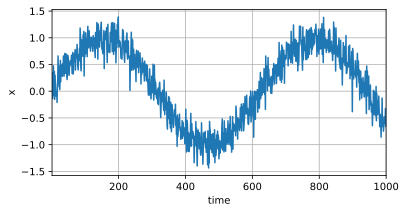

In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000 # 总共产⽣1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
  features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本⽤于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),batch_size, is_train=True)

# 初始化⽹络权重的函数
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)
# ⼀个简单的多层感知机
def get_net():
  net = nn.Sequential(nn.Linear(4, 10),
             nn.ReLU(),
             nn.Linear(10, 1))
  net.apply(init_weights)
  return net
# 平⽅损失。注意：MSELoss计算平⽅误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

def train(net, train_iter, loss, epochs, lr):
  trainer = torch.optim.Adam(net.parameters(), lr)
  for epoch in range(epochs):
    for X, y in train_iter:
      trainer.zero_grad()
      l = loss(net(X), y)
      l.sum().backward()
      trainer.step()
    print(f'epoch {epoch + 1}, '
      f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)


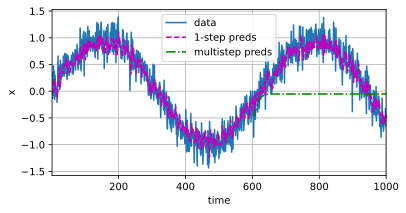

In [ ]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',    #其中的x代表y值
    'x', legend=['data', '1-step preds'], xlim=[1, 1000],
    figsize=(6, 3))

multistep_preds = torch.zeros(T)            #前(604)半部分是保存真实值,后半部分是预测值
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
  multistep_preds[i] = net(
    multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time',
    'x', legend=['data', '1-step preds', 'multistep preds'],
    xlim=[1, 1000], figsize=(6, 3))

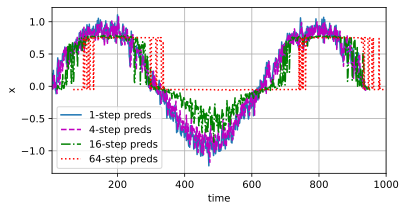

In [ ]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来⾃x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
  features[:, i] = x[i: i + T - tau - max_steps + 1]
# 列i（i>=tau）是来⾃（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
  features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
    [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
    legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
    figsize=(6, 3))


文本预处理

In [ ]:
import collections
import re
from d2l import torch as d2l


d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt','090b5e7e70c295757f55df93cb0a180b9691891a')
def read_time_machine():
#将时间机器数据集加载到⽂本⾏的列表中
  with open(d2l.download('time_machine'), 'r') as f:
    lines = f.readlines()
  return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# ⽂本总⾏数: {len(lines)}')
print(lines[0])
print(lines[10])

# ⽂本总⾏数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [ ]:
def tokenize(lines, token='word'):
#将⽂本⾏拆分为单词或字符词元
  if token == 'word':
    return [line.split() for line in lines]
  elif token == 'char':
    return [list(line) for line in lines]
  else:
    print('错误：未知词元类型：' + token)

tokens = tokenize(lines)
for i in range(11):
  print(tokens[i])

class Vocab:
#⽂本词表
  def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
    if tokens is None:
     tokens = []
    if reserved_tokens is None:
     reserved_tokens = []
  # 按出现频率排序
    counter = count_corpus(tokens)
    self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                               reverse=True)   #x[1]表示键值对第二个元素也就是频率,由高→低

# 未知词元的索引为0
    self.idx_to_token = ['<unk>'] + reserved_tokens    #这道题reserved_tokens为空
    self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
    for token, freq in self._token_freqs:
     if freq < min_freq:
       break      #频率小于min_freq，则停止添加词元到词表中
     if token not in self.token_to_idx:
       self.idx_to_token.append(token)
       self.token_to_idx[token] = len(self.idx_to_token) - 1

def __len__(self):
  return len(self.idx_to_token)

#如果输入是单个词元，返回其索引；如果输入是词元列表或元组，返回对应的索引列表
def __getitem__(self, tokens):
  if not isinstance(tokens, (list, tuple)):
    return self.token_to_idx.get(tokens, self.unk)  #检查tokens是否为列表或元组类型，如果不是，则表示tokens为单个词语。
#在这种情况下，代码使用self.token_to_idx.get(tokens, self.unk)来获取词语tokens在词汇表中的索引。
  return [self.__getitem__(token) for token in tokens]   #因为__getitem__(self, tokens)函数只接受单个单词,所以用递归

#如果输入是单个索引，返回对应的词元；如果输入是索引列表或元组，返回对应的词元列表
def to_tokens(self, indices):
  if not isinstance(indices, (list, tuple)):
    return self.idx_to_token[indices]
  return [self.idx_to_token[index] for index in indices]

@property
def unk(self): # 未知词元的索引为0
  return 0
@property
def token_freqs(self):
  return self._token_freqs
def count_corpus(tokens):
#统计词元的频率
# 这⾥的tokens是1D列表或2D列表
  if len(tokens) == 0 or isinstance(tokens[0], list):
# 将词元列表展平成⼀个列表
    tokens = [token for line in tokens for token in line]
  return collections.Counter(tokens)

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
